# Evaluate GradientBoostingRegressor with TSCV & Cross_Validade:

Categorical Columns:
Index(['StoreType', 'AssortmentType'], dtype='object')
 
 
Head of Training Data:
   StoreID  IsHoliday  IsOpen  HasPromotions  StoreType  AssortmentType  \
0     1000          0       1              0          0               0   
1     1000          0       1              0          0               0   
2     1000          0       1              0          0               0   

   NearestCompetitor  Region  NumberOfSales  Region_AreaKM2  Region_GDP  \
0                326       7           5676            9643       17130   
1                326       7           8111            9643       17130   
2                326       7           8300            9643       17130   

   Region_PopulationK  Year  Month (number)  Week  Day of year  Day of month  \
0                2770  2016               3    10           61             1   
1                2770  2016               3    10           62             2   
2                2770  2016               3    10      

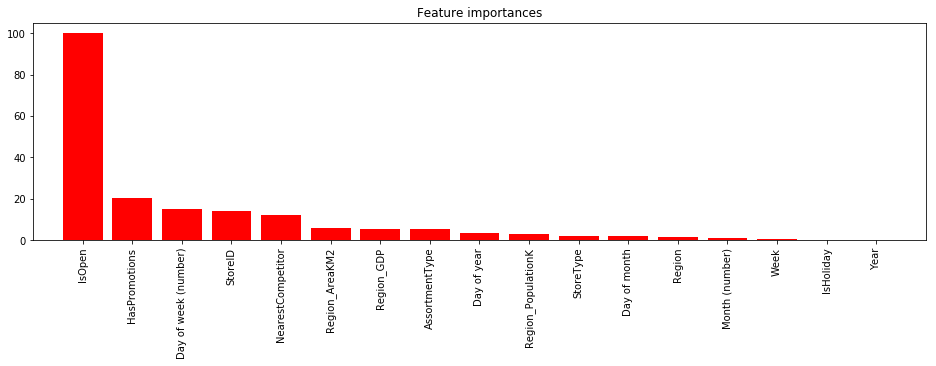

 
Model Parameters:
{'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 37, 'n_iter_no_change': 3, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'tol': 0.1, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Win
7
3.6.7
sklearn
0.20.2
***Process Completed***


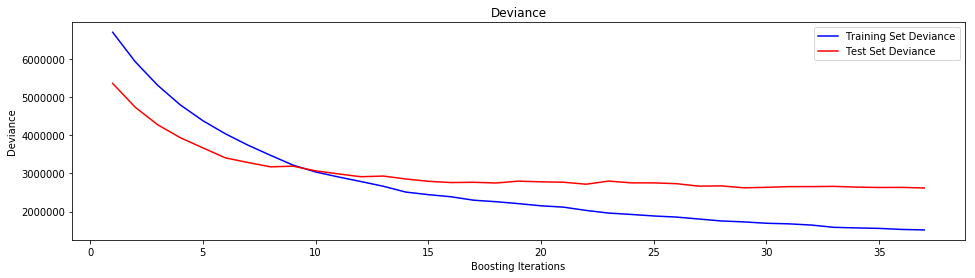

In [45]:
#from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
import csv
import sys
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
trainBench = pd.read_csv("c:/Benchmarking/trainBench.csv")
#testBench = pd.read_csv("c:/Benchmarking/testBench.csv")

trainBench = trainBench.drop("ID", axis=1)

cat_columns = trainBench.select_dtypes(['object']).columns
print("Categorical Columns:")
print(cat_columns)
trainBench[cat_columns] = trainBench[cat_columns].astype('category')
cat_columns = trainBench.select_dtypes(['category']).columns
trainBench[cat_columns] = trainBench[cat_columns].apply(lambda x: x.cat.codes)
Int64columns = trainBench.select_dtypes(['int64']).columns
#Int64columns
trainBench[Int64columns] = trainBench[Int64columns].astype(np.int32)

print(" ")
print(" ")
print("Head of Training Data:")
print(trainBench.head(3))

# Split Features and Responses
print(" ")
print(" ")
print("Train Data Type Descriptions:")
TrainDataTypes=trainBench.dtypes
print(TrainDataTypes)
#trainBench.info()
mask = trainBench.columns.difference(['NumberOfSales'])
trainDataset_X = trainBench[mask]
print(" ")
print(" ")
print("Feature Columns:")
print(mask)
trainDataset_y = trainBench['NumberOfSales']
#del trainBench

#**************Insert comments about this run here:

#{'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 37}
Comments="'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 37, TS CV"
Algo='GradientBoostingRegressor'

start=time.time()
forest = GradientBoostingRegressor(n_estimators=37, 
                             loss="ls",
                             max_features = int(trainDataset_X.columns.size - 5),
                             n_iter_no_change=3,
                             min_samples_leaf=1,
                             min_samples_split=10,
                             tol=0.1,
                             #verbose=1,
                             max_depth = 5,
                             random_state=0)
forest.fit(trainDataset_X, trainDataset_y)
M_FitTime = time.time() - start
print(" ")
print(" ")
print("Measured Fit Time: ", M_FitTime)

UseTScv=True
if UseTScv:
    from sklearn.model_selection import TimeSeriesSplit
    print("Using Time Series Cross Validation")
    start=time.time()
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        
else:
    from sklearn.model_selection import KFold
    print("Using KFold Cross Validation")
    start=time.time()
    kfolds = KFold(n_splits=5,shuffle=False,random_state=0)
    scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=kfolds, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )
    
XValidTime = time.time() - start

print(" ")
print(" ")
print("Cross Validation Performance: ")
print("Cross Validation Time: %0.2f" % (XValidTime))
EV=scores['test_explained_variance'].mean()
print(scores['test_explained_variance'])
print("EV: %0.2f" % (EV))
#MAE is less sensitive to outliers, The contant value that minimizes the MAE is the median of the target values
print(-1*scores['test_neg_mean_absolute_error'])
MAE=-1*scores['test_neg_mean_absolute_error'].mean()
print("MAE: %0.2f" % (MAE))
#MAE considers outliers, The contant value that minimizes the MSE is the mean of the target values
#If you think your outliers are erros in the data use MAE, if you think the outliers are true datapoints use MSE.
#It is easier to optmize MSE than RMSE because RMSE requires an adjustable learning rate.
print(-1*scores['test_neg_mean_squared_error'])
MSE=-1*scores['test_neg_mean_squared_error'].mean()
print("MSE: %0.2f" % (MSE))
print(np.sqrt(-1*scores['test_neg_mean_squared_error']))
RMSE=np.sqrt(-1*scores['test_neg_mean_squared_error'].mean())
print("RMSE: %0.2f" % (RMSE))
#Optimizing R2 and optimizing for MSE is the same, since R2 = 1-(MSE/Constant)
print("XV R2 Actuals:",scores['test_r2'])
R2=scores['test_r2'].mean()
print("Cross Validation R2: %0.2f" % (R2))
print("XVR_fit_time Actuals: ", (scores['fit_time']))
XVR_FT=scores['fit_time'].mean()
print("XVR_fit_time: %0.2f" % (XVR_FT))
print("score_time Actuals: ", (scores['score_time']))      
ST=scores['score_time'].mean()
print("score_time: %0.2f" % (ST))
Params=forest.get_params(deep=True)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

validBench = pd.read_csv("c:/Benchmarking/validBench.csv")
validBench = validBench.drop("ID", axis=1)
#Int64columns = validBench.select_dtypes(['int64']).columns
#Int64columns
validBench[Int64columns] = validBench[Int64columns].astype(np.int32)

print(" ")
print(" ")
print("Converting Validation Categorical Columns to Numbers:")
cat_columns
validBench[cat_columns] = validBench[cat_columns].astype('category')
cat_columns = validBench.select_dtypes(['category']).columns
validBench[cat_columns] = validBench[cat_columns].apply(lambda x: x.cat.codes)
print(" ")
print(" ")
print("Head of Validation Data:")
print(validBench.head(3))
print(" ")
print(mask)
validBench_X = validBench[mask]
validBench_y = validBench['NumberOfSales']

start=time.time()
y_pred=forest.predict(validBench_X)
PredTime = time.time() - start

print(" ")
print(" ")
print("Prediction Time: ", PredTime)
print(" ")
print("Validation Performance with ~20.000 records:")
EVv=explained_variance_score(validBench_y, y_pred)
print("Validation Set Explained Variance (EV): %0.2f" % (EVv))
#MAE is less sensitive to outliers, The constant value that minimizes the MAE is the median of the target values
MAEv=mean_absolute_error(validBench_y, y_pred)
print("MAE: %0.2f" % (MAEv))
#MAE considers outliers, The contant value that minimizes the MSE is the mean of the target values
#If you think your outliers are erros in the data use MAE, if you think the outliers are true datapoints use MSE.
#It is easier to optmize MSE than RMSE because RMSE requires an adjustable learning rate.
MSEv=mean_squared_error(validBench_y, y_pred)
print("MSE: %0.2f" % (MSEv))
RMSEv=np.sqrt(MSEv)
print("RMSE: %0.2f" % (RMSEv))
#Optimizing R2 and optimizing for MSE is the same, since R2 = 1-(MSE/Constant)
R2v=r2_score(validBench_y, y_pred)
print("Validation Set R2: %0.2f" % (R2v))
EVtot=scores['test_explained_variance'].copy()
EVtot = np.append(EVtot,EVv)
print("Total Mean EV: ",EVtot,EVtot.mean())



#Calculate Feature importances and Graph:

importances = forest.feature_importances_
# make importances relative to max importance
importances = 100.0 * (importances / importances.max())

#std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print(" ")
print(" ")
print("Feature Importances:")
d=[]
for f in range(trainDataset_X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], trainDataset_X.columns[indices[f]], importances[indices[f]]))
    d.append({"%d. feat: %d %s (%f)" % (f + 1, indices[f], trainDataset_X.columns[indices[f]], importances[indices[f]])})

Feat_Imp = pd.DataFrame(d)

# #############################################################################
# Plot the feature importances of the forest
plt.figure(figsize=(16,4))
plt.title("Feature importances")
plt.bar(range(trainDataset_X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(trainDataset_X.shape[1]), trainDataset_X.columns[indices],rotation=90)
plt.xlim([-1, trainDataset_X.shape[1]])
plt.show()

# Plot training deviance
# compute test set deviance
test_score = np.zeros((Params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(forest.staged_predict(validBench_X)):
    test_score[i] = forest.loss_(validBench_y, y_pred)

plt.figure(figsize=(16, 4))
#plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(Params['n_estimators']) + 1, forest.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(Params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')


print(" ")
print("Model Parameters:")
print(Params)

import platform
import sys
OpSys=platform.system()[:3]
print(OpSys)
OpSysVer=platform.release()
print(OpSysVer)
LangVer=sys.version[:5]
print(LangVer)
import sklearn
Lib='sklearn'
print(Lib)
LibVer= sklearn.__version__
print(LibVer)

from openpyxl import load_workbook
workbook_name = 'C:\\Benchmarking\\AlgoPerf.xlsx'
def xlsADD(row):
    wb = load_workbook(workbook_name)
    page = wb.active
    page.append(row)
    wb.save(filename=workbook_name)            
            
def InsertHeader():
    Result=('OpSys','OpVer', 
            'Lang', 
            'LangVer', 
            'Lib', 
            'Lib.Ver', 
            'Algo',
            'M_FitTime', 
            'XVR_FitTime',
            'XVR_ScorTime',
            'XV_Time',
            'XV_EV',
            'XV_MAE', 
            'XV_MSE', 
            'XV_RMSE', 
            'XV_R2',
            'TS_PredTime',
            'TS_EV',
            'TS_MAE', 
            'TS_MSE', 
            'TS_RMSE', 
            'TS_R2',
            'MeanEV',
            'MdlParam', 
            'FeatImp',
            'TdTypes',
            'Comments')
    #print(Result)
    xlsADD(Result)
    
def InsertValues():
    Result=(OpSys, 
            OpSysVer, 
            'Python', 
            LangVer, 
            Lib, 
            LibVer,
            Algo,
            M_FitTime, 
            XVR_FT,
            ST,
            XValidTime,
            EV,
            MAE, 
            MSE, 
            RMSE, 
            R2,
            PredTime,
            EVv,
            MAEv, 
            MSEv, 
            RMSEv, 
            R2v,
            EVtot.mean(),
            str(Params), 
            str(d),
            str(TrainDataTypes),
            Comments)
    #print(Result)
    xlsADD(Result)

#InsertHeader()
InsertValues()
print('***Process Completed***')

In [42]:
#Randomize Search:
import numpy as np
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import RandomForestRegressor

# Load data
X, y = trainDataset_X, trainDataset_y
#del(trainDataset_X, trainDataset_y)

# build model
n_iter_search = 20
clf = GradientBoostingRegressor(verbose=1,
                                loss="ls",
                                n_iter_no_change=3,
                                tol=0.1,
                                random_state=0)

# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"n_estimators": [31,37], #sp_randint(37),
              "max_depth": [4,5],
              "max_features": [12],
              "min_samples_split": [5,10],
              "min_samples_leaf" : [1,2]
              }

from sklearn.model_selection import TimeSeriesSplit
print("Using Time Series Cross Validation")
tscv = TimeSeriesSplit(n_splits=5)
#scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        


# run randomized search
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=tscv, n_jobs=-1)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

Using Time Series Cross Validation


c:\program files\python36\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


      Iter       Train Loss   Remaining Time 
         1     6727068.7750            2.81s
         2     5986907.1442            3.17s
         3     5363828.2641            3.09s
         4     4868170.5156            2.97s
         5     4465902.6053            2.93s
         6     4137821.9599            2.86s
         7     3871540.2925            2.73s
         8     3654350.6885            2.69s
         9     3433356.7762            2.59s
        10     3288443.3374            2.51s
        20     2424339.1222            1.35s
        30     2048157.9903            0.12s
RandomizedSearchCV took 112.72 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.580 (std: 0.054)
Parameters: {'n_estimators': 31, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 12, 'max_depth': 4}

Model with rank: 1
Mean validation score: 0.580 (std: 0.054)
Parameters: {'n_estimators': 31, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1

In [58]:
from noisyopt import minimizeCompass
tscv = TimeSeriesSplit(n_splits=5)

def obj(loss="ls", learning_rate=0.1, n_estimators=100, subsample=1.0, criterion="friedman_mse", min_samples_split=2,
        min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
        min_impurity_split=None, init=None, random_state=0, max_features=None, alpha=0.9, verbose=0,
        max_leaf_nodes=None, warm_start=False, presort="auto", validation_fraction=0.1, n_iter_no_change=None,
        tol=0.0001):
    forest = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample,
        criterion=criterion, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_depth=max_depth, min_impurity_decrease=min_impurity_decrease,
        min_impurity_split=min_impurity_split, init=init, random_state=random_state, max_features=max_features, alpha=alpha, verbose=verbose,
        max_leaf_nodes=max_leaf_nodes, warm_start=warm_start, presort=presort, validation_fraction=validation_fraction, n_iter_no_change=n_iter_no_change,
        tol=tol)
    scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        
    print(forest.get_params(deep=True))
    return scores['test_explained_variance'].mean()

param_dist = {"n_estimators": [5,10], #sp_randint(37),
              "max_depth": [4,5],
              "max_features": sp_randint(8,17),
              "min_samples_split": sp_randint(4,10),
              "min_samples_leaf" : [1,2]
              }
bounds = param_dist #[[3, 4], [0.5, 5.0]]
x0 = np.array([-2.0, 2.0])
res = minimizeCompass(obj, x0=[param_dist], deltatol=0.1, paired=False, errorcontrol=False, **param_dist)
print(res)

TypeError: unsupported operand type(s) for +: 'dict' and 'float'

In [49]:
minimizeCompass??

In [27]:
obj(n_estimators=5,verbose=1)

      Iter       Train Loss   Remaining Time 
         1     5761438.9682            0.04s
         2     5047711.8932            0.03s
         3     4466692.5309            0.02s
         4     3993702.4958            0.01s
         5     3605101.5518            0.00s
      Iter       Train Loss   Remaining Time 
         1     5548484.6642            0.06s
         2     4868065.9439            0.07s
         3     4315542.7413            0.04s
         4     3865392.2057            0.02s
         5     3498240.2888            0.00s
      Iter       Train Loss   Remaining Time 
         1     6391915.9902            0.15s
         2     5705022.6164            0.11s
         3     5146577.1232            0.07s
         4     4691366.2069            0.04s
         5     4321333.4431            0.00s
      Iter       Train Loss   Remaining Time 
         1     6333250.1837            0.21s
         2     5653356.2438            0.14s
         3     5101253.9050            0.09s
      

0.3609305502964412

In [39]:
random_search.cv_results_

c:\program files\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\program files\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\program files\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\program files\python36\lib\site-packages\sklearn\

{'mean_fit_time': array([9.93234191]),
 'std_fit_time': array([0.06934554]),
 'mean_score_time': array([0.02808013]),
 'std_score_time': array([0.00623996]),
 'param_n_estimators': masked_array(data=[30],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[13],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 30,
   'min_samples_split': 2,
   'min_samples_leaf': 2,
   'max_features': 13,
   'max_depth': 4}],
 'split0_test_score': array([0.63367835]),
 'split1_test_score': array([0.

RandomizedSearchCV took 2096.13 seconds for 300 candidates parameter settings. TSCV
Model with rank: 1
Mean validation score: 0.580 (std: 0.054)
Parameters: {'max_depth': 4, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 31}

Model with rank: 1
Mean validation score: 0.583 (std: 0.070)
Parameters: {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 37}

Model with rank: 1
Mean validation score: 0.580 (std: 0.063)
Parameters: {'loss': 'ls', 'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 40}
RandomizedSearchCV took 325.39 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.580 (std: 0.073)
Parameters: {'loss': 'ls', 'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 35}

Model with rank: 2
Mean validation score: 0.561 (std: 0.086)
Parameters: {'loss': 'huber', 'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 30}

Model with rank: 3
Mean validation score: 0.559 (std: 0.087)
Parameters: {'loss': 'huber', 'max_depth': 4, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 30}

Model with rank: 4
Mean validation score: 0.558 (std: 0.090)
Parameters: {'loss': 'huber', 'max_depth': 4, 'max_features': 16, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 25}

Model with rank: 5
Mean validation score: 0.551 (std: 0.076)
Parameters: {'loss': 'ls', 'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 35}

Model with rank: 6
Mean validation score: 0.545 (std: 0.095)
Parameters: {'loss': 'lad', 'max_depth': 5, 'max_features': 11, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 25}


In [44]:
#GridSearchCV Search:
from sklearn.model_selection import GridSearchCV
# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

c:\program files\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

In [1]:
#Load the data
#from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
import csv
import sys
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
trainBench = pd.read_csv("c:/Benchmarking/trainBench.csv")
#testBench = pd.read_csv("c:/Benchmarking/testBench.csv")

trainBench = trainBench.drop("ID", axis=1)

cat_columns = trainBench.select_dtypes(['object']).columns
print("Categorical Columns:")
print(cat_columns)
trainBench[cat_columns] = trainBench[cat_columns].astype('category')
cat_columns = trainBench.select_dtypes(['category']).columns
trainBench[cat_columns] = trainBench[cat_columns].apply(lambda x: x.cat.codes)
Int64columns = trainBench.select_dtypes(['int64']).columns
#Int64columns
trainBench[Int64columns] = trainBench[Int64columns].astype(np.int32)

print(" ")
print(" ")
print("Head of Training Data:")
print(trainBench.head(3))

# Split Features and Responses
print(" ")
print(" ")
print("Train Data Type Descriptions:")
TrainDataTypes=trainBench.dtypes
print(TrainDataTypes)
#trainBench.info()
mask = trainBench.columns.difference(['NumberOfSales'])
trainDataset_X = trainBench[mask]
print(" ")
print(" ")
print("Feature Columns:")
print(mask)
trainDataset_y = trainBench['NumberOfSales']

Categorical Columns:
Index(['StoreType', 'AssortmentType'], dtype='object')
 
 
Head of Training Data:
   StoreID  IsHoliday  IsOpen  HasPromotions  StoreType  AssortmentType  \
0     1000          0       1              0          0               0   
1     1000          0       1              0          0               0   
2     1000          0       1              0          0               0   

   NearestCompetitor  Region  NumberOfSales  Region_AreaKM2  Region_GDP  \
0                326       7           5676            9643       17130   
1                326       7           8111            9643       17130   
2                326       7           8300            9643       17130   

   Region_PopulationK  Year  Month (number)  Week  Day of year  Day of month  \
0                2770  2016               3    10           61             1   
1                2770  2016               3    10           62             2   
2                2770  2016               3    10      

$$
\sqrt{2}
$$

In [4]:
? GradientBoostingRegressor

In [5]:
?? RandomizedSearchCV

In [ ]:
RandomizedSearchCV??

In [14]:
EVtot?

In [ ]:
def csvADD (line):
    if sys.version_info > (3,4):
        #print("Running Python 3.X")
        with open('C:\\Benchmarking\\AlgoPerf.csv', 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(line)
    else:
        with open(r'C:\\Benchmarking\\AlgoPerf.csv', 'ab') as file:
            writer = csv.writer(file)
            writer.writerow(line)

In [14]:
!pip list|grep xgboost

xgboost                           0.81                 


In [38]:
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
#scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=kfolds, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )

X = trainDataset_X
y = trainDataset_y
 
for train_index, test_index in tscv.split(y):
   print("TRAIN:", train_index, "TEST:", test_index)

   

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [    0     1     2 ... 16760 16761 16762] TEST: [16763 16764 16765 ... 33518 33519 33520]
TRAIN: [    0     1     2 ... 33518 33519 33520] TEST: [33521 33522 33523 ... 50276 50277 50278]
TRAIN: [    0     1     2 ... 50276 50277 50278] TEST: [50279 50280 50281 ... 67034 67035 67036]
TRAIN: [    0     1     2 ... 67034 67035 67036] TEST: [67037 67038 67039 ... 83792 83793 83794]
TRAIN: [    0     1     2 ... 83792 83793 83794] TEST: [ 83795  83796  83797 ... 100550 100551 100552]


http://bioinfo.ihb.ac.cn/softwares/PypeR/